In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
a, b, c = 100, 150, 200

n_zs = 200
dist = c / n_zs

zs = np.linspace(-c+dist/2, c-dist/2, 40)
# xs = a * cos(theta) * np.cos(phi)
# ys = b * cos(theta) * np.sin(phi)
# zs = c * sin(theta)
# sin(thetas) = zs/c
thetas = np.arcsin(zs/c)
av_rhos = (a + b) * np.cos(thetas) / 2
n_cells = np.ceil(av_rhos/dist).astype(np.int)

phis = np.concatenate(
    [np.linspace(-np.pi, np.pi,
                 nc, endpoint=False)
     + (np.pi/nc) * (i%2)
     for i, nc in enumerate(n_cells)])
zs = np.concatenate(
    [z * np.ones(nc)
     for z, nc in zip(zs, n_cells)])
thetas = np.concatenate(
    [theta * np.ones(nc)
     for theta, nc in zip(thetas, n_cells)])

xs = a * np.cos(thetas) * np.cos(phis)
ys = b * np.cos(thetas) * np.sin(phis)


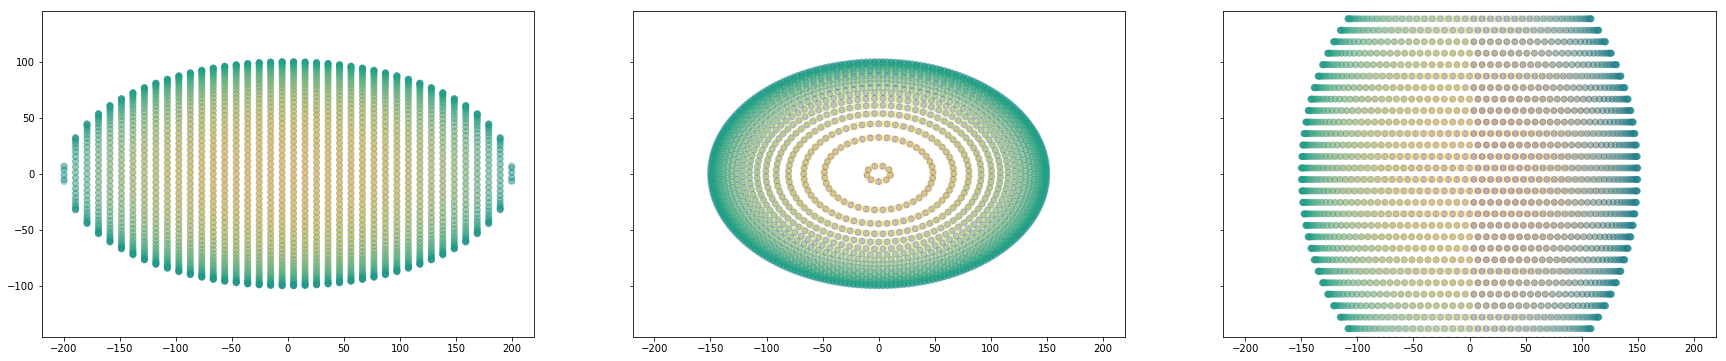

In [182]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)


fig.set_size_inches(30, 6)
axes[0].scatter(zs, xs, c=ys,
                alpha=0.3)
axes[1].scatter(ys, xs, c=zs,
                alpha=0.3)
axes[2].scatter(ys, zs, c=xs,
                alpha=0.3)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

In [120]:
ys.shape

(5360,)

In [310]:
from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw  

In [352]:
def get_subeptm(cond, coords):
    
    
    f_ids = np.arange(ys.size)
    points = np.vstack([xs[cond],
                        ys[cond],
                        zs[cond]]).T

    voro = Voronoi(points[:, coords[:2]])
    datasets = from_2d_voronoi(voro)

    eptm = Epithelium('3D_test', datasets,
                      config.geometry.spherical_sheet())
    eptm.face_df['z'] = points[:, coords[2]]
    eptm.face_df['f_ids'] = f_ids[cond]
    eptm.edge_df['f_ids'] = eptm.upcast_face(eptm.face_df['f_ids'])
    eptm.sanitize()
    eptm.edge_df['z'] = eptm.upcast_face(eptm.face_df['z'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['z'].mean()
    coords = [list('xyz')[c] for c in coords]
    eptm.vert_df[['x', 'y', 'z']] = eptm.vert_df[coords]
    SheetGeometry.update_all(eptm)
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_fids'] = eptm.edge_df.loc[
        eptm.edge_df['opposite'].values,
        'f_ids'].values.astype(np.int)
    return eptm

In [353]:
eptm_zpos = get_subeptm(zs>=0, [0, 1, 2])
eptm_zneg = get_subeptm(zs<=0, [0, 1, 2])
eptm_ypos = get_subeptm(ys>=0, [0, 2, 1])
eptm_yneg = get_subeptm(ys<=0, [0, 2, 1])



In [359]:
eptm = eptm_zpos
(eptm_zpos.edge_df[['f_ids', 'opp_fids']].head(),
 eptm_ypos.edge_df[['f_ids', 'opp_fids']].head())

(      f_ids  opp_fids
 edge                 
 0      3851      3836
 1      3836      3851
 2      3836      3835
 3      3835      3836
 4      3837      3836,       f_ids  opp_fids
 edge                 
 0      1892      2017
 1      2017      1892
 2      2017      1891
 3      1891      2017
 4      2017      2016)

In [361]:
eptm_ = eptm.edge_df.set_index(['f_ids', 'opp_fids'])

In [363]:
eptm_.sort_index()

trgt  face  srce         dx            dy          nz  \
f_ids opp_fids                                                          
2052  NaN       1698     0   190  31.122376 -1.379205e+00   47.468686   
      NaN        190     0   191 -30.993669 -2.421081e+00   47.761993   
      2177.0     191     0   470  -0.574706  7.565971e-02    1.602795   
      2178.0    1699     0  1698   0.416966  6.868345e-02    1.165703   
      2301.0     470     0  1699   0.029033  3.655943e+00   23.793955   
2053  NaN       1692     1  1026  31.087009 -3.339071e-01   46.917206   
      NaN       1026     1  1701 -30.701970 -3.448322e+00   47.792773   
      2178.0    1701     1  1702  -0.732447  7.270104e-02    2.037058   
      2179.0    1695     1  1692   0.261518  5.194955e-02    0.732693   
      2302.0    1702     1  1695   0.085889  3.657578e+00   23.664240   
2054  NaN        177     2    54  30.888869  7.036195e-01   46.116660   
      NaN         54     2  1690 -30.250707 -4.449919e+00   47.561567   
      2179.0    1690     2  1691  -0.887936  5.983712e-02    2.461673   
      2180.0     179     2   177   0.110621  2.584225e-02    0.310532   
      2303.0    1691     2   179   0.139153  3.660620e+00   23.407185   
2055  NaN       1024     3  1022 -29.645589 -5.415289e+00   30.220772   
      NaN       1025     3  1024  30.498416  1.720556e+00   56.344121   
      2180.0    1022     3  1023  -1.039018  3.729652e-02    2.634836   
      2304.0    1023     3  1025   0.186191  3.657436e+00   28.758185   
2056  NaN        463     4    56  29.854425  2.696982e+00   54.753124   
      NaN         56     4  1019 -28.894475 -6.334481e+00   29.710294   
      2181.0    1019     4  1020  -1.183696  5.490992e-03    2.989296   
      2305.0    1020     4   463   0.223746  3.632008e+00   28.032125   
2057  NaN        994     5  1034 -28.007210 -7.198375e+00   29.063527   
      NaN        993     5   994  29.076269  3.626584e+00   52.923217   
      2182.0    1034     5  1035  -1.320185 -3.500720e-02    3.318895   
      2306.0    1035     5   993   0.251126  3.606798e+00   27.178585   
2058  NaN       1671     6   995  28.175277  4.501534e+00   50.884262   
      NaN        995     6  1674 -26.995414 -7.998850e+00   28.292268   
      2183.0    1674     6  1676  -1.446955 -8.349389e-02    3.619747   
...              ...   ...   ...        ...           ...         ...   
3850  3853.0      29  1798   132   0.454335 -1.717774e+00   19.102175   
3851  3828.0     380  1799   381  -0.692190  1.282315e+00   10.060955   
      3829.0       3  1799   380  -2.955589  3.433968e+00   22.352494   
      3830.0      41  1799     3  -2.983992  2.349424e+00   14.589269   
      3831.0      40  1799    41  -2.570886  1.388680e+00    9.929124   
      3832.0     302  1799    40  -1.898272  6.736398e-01    6.774260   
      3833.0     303  1799   302  -1.208811  2.442791e-01    4.371857   
      3834.0      18  1799   303  -0.734076  4.825019e-02    2.807352   
      3835.0       0  1799    18  -0.624032 -4.047938e-02    2.570454   
      3836.0       1  1799     0  -0.902382 -1.792658e-01    4.064856   
      3837.0     107  1799     1  -1.463189 -5.053323e-01    7.403227   
      3838.0     108  1799   107  -2.108167 -1.092919e+00   12.580784   
      3839.0     134  1799   108  -0.768752 -5.692888e-01    5.843496   
      3850.0     381  1799   131  13.061138  1.508170e+01  233.836720   
      3852.0     131  1799   134   5.849200 -2.211497e+01  170.381236   
3852  3839.0     135  1800   134  -2.116083 -1.156881e+00   18.524921   
      3840.0     133  1800   135  -3.324152 -2.687107e+00   28.013351   
      3841.0     393  1800   133  -3.131643 -3.833169e+00   29.090585   
      3842.0    1568  1800   393  -2.362725 -4.872889e+00   32.259499   
      3843.0    1567  1800  1568  -0.294468 -1.474966e+00   10.587167   
      3850.0     131  1800   132   0.337220  1.274978e+00   15.634454   
      3851.0     134  1800   131  -5.849200  2.211497e+01  136.417259   
 

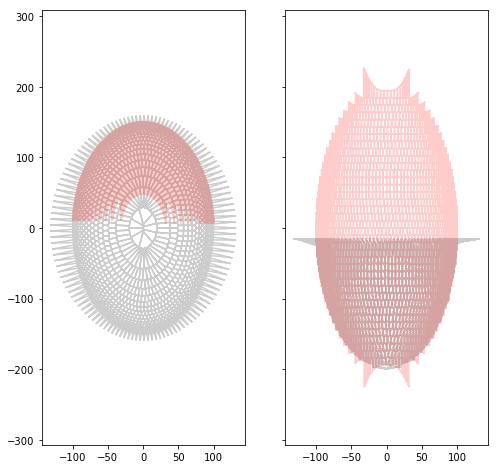

In [313]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
quick_edge_draw(eptm_zpos, ax=ax[0], c='k', alpha=0.2)
quick_edge_draw(eptm_zneg, ax=ax[1], c='k',
                alpha=0.2, coords=['x', 'z'])
quick_edge_draw(eptm_ypos, ax=ax[0], c='r', alpha=0.2)
quick_edge_draw(eptm_yneg, ax=ax[1], c='r',
                alpha=0.2, coords=['x', 'z'])
fig.set_size_inches((8,8))
ax[0].set_aspect('equal')


In [314]:
com_yn_zn = set(eptm_yneg.face_df['f_ids']).intersection(
    eptm_zneg.face_df['f_ids'])

In [315]:
com_yn_zn


{10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 

In [308]:
f_yn = eptm_yneg.face_df[eptm_yneg.face_df['f_ids'] == 115]
f_zn = eptm_zneg.face_df[eptm_zneg.face_df['f_ids'] == 115]

e_yn = eptm_yneg.edge_df[eptm_yneg.edge_df['f_ids'] == 115]
e_zn = eptm_zneg.edge_df[eptm_zneg.edge_df['f_ids'] == 115]
iv_yn = e_yn['srce'].values
iv_zn = e_zn['srce'].values

v_yn = eptm_yneg.vert_df.loc[iv_yn, list('xyz')]
v_zn = eptm_zneg.vert_df.loc[iv_zn, list('xyz')]


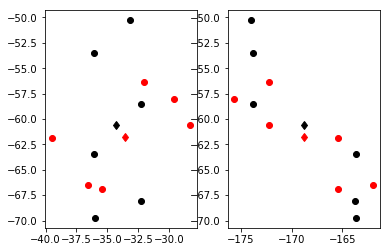

In [309]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(v_yn.x, v_yn.y, 'ko')
ax[0].plot(v_zn.x, v_zn.y, 'ro')
ax[0].plot(f_yn.x, f_yn.y, 'kd')
ax[0].plot(f_zn.x, f_zn.y, 'rd')

ax[1].plot(v_yn.z, v_yn.y, 'ko')
ax[1].plot(v_zn.z, v_zn.y, 'ro')
ax[1].plot(f_yn.z, f_yn.y, 'kd')
ax[1].plot(f_zn.z, f_zn.y, 'rd')



In [274]:
v_zn

,x,y,z
vert,,,
1909,12.521084,-141.661876,-61.382133
1266,93.567074,-51.578343,-10.263501
1257,94.648946,-48.115660,-0.031727
1911,12.521084,-143.184724,-51.162490
1889,72.944034,-95.351669,-51.170058
1888,73.071807,-94.416078,-51.130621


In [278]:
rdr, lines = view_3js(eptm_ypos)
rdr

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
